In [1]:
# this part below is a bit of cut/paste from the other notebook
import datetime
import matplotlib.pyplot as plt
import numpy as np
import openml
import seaborn as sns

from sklearn.decomposition import KernelPCA
from sklearn.metrics import r2_score

# state-of-the-art ensemble regressors
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

def get_point_in_semantic_space(predictor, X, y_true) :
    
    y_pred = predictor.predict(X)

    return np.subtract(y_true, y_pred)

def get_points_in_semantic_space_from_predictors(predictors, X, y_true) :
    
    semantic_points = np.zeros((len(predictors), y_true.shape[0]))
    
    for i, predictor in enumerate(predictors) :
        semantic_points[i,:] = get_point_in_semantic_space(predictor, X, y_true)
        
    return semantic_points

# set a nice style for the plots (hopefully)
sns.set_style()

# hard-coded values
random_seed = 42
n_estimators = 100

# load OpenML-CTR23, a regression benchmark suite with 35 benchmarks
suite = openml.study.get_suite(353)
print(suite)

# let's focus on a specific task, for the moment
# 361249 is 'white_wine', 4898 samples and 12 features
task_ids = [361249]

task_id = task_ids[0]

print("Now working on task #%d..." % task_id)

# we also get the indices of the first fold, to use them as a measure of effectiveness
task = openml.tasks.get_task(task_id)
train_indices, test_indices = task.get_train_test_split_indices(repeat=0, fold=0, sample=0)

dataset = task.get_dataset()
X_df, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
X = X_df.values
print("X:", X)
print("y:", y.shape)
print("Column names:", attribute_names)

# get the split
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print("Creating reference points...")
#reference_points = create_kpca_reference_points(y.shape[0])
rng = np.random.default_rng(seed=random_seed)
reference_points = rng.standard_normal(size=(X_train.shape[0], X_train.shape[0]))

print("Computing cosine-similarity kPCA...")
kpca = KernelPCA(n_components=2, kernel='cosine', random_state=random_seed)
rp_pca = kpca.fit_transform(reference_points)

OpenML Benchmark Suite
ID..............: 353
Name............: OpenML-CTR23 - A curated tabular regression benchmarking suite
Status..........: in_preparation
Main Entity Type: task
Study URL.......: https://www.openml.org/s/353
# of Data.......: 35
# of Tasks......: 35
Creator.........: https://www.openml.org/u/30127
Upload Time.....: 2023-05-31 16:39:49
Now working on task #361249...
X: [[ 7.    0.27  0.36 ...  3.    0.45  8.8 ]
 [ 6.3   0.3   0.34 ...  3.3   0.49  9.5 ]
 [ 8.1   0.28  0.4  ...  3.26  0.44 10.1 ]
 ...
 [ 6.5   0.24  0.19 ...  2.99  0.46  9.4 ]
 [ 5.5   0.29  0.3  ...  3.34  0.38 12.8 ]
 [ 6.    0.21  0.38 ...  3.26  0.32 11.8 ]]
y: (4898,)
Column names: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Creating reference points...


C:\Users\Alberto\anaconda3\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
C:\Users\Alberto\anaconda3\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


Computing cosine-similarity kPCA...


In [3]:
print("Now working with Gradient Boosting...")
gb_regressor = GradientBoostingRegressor(random_state=random_seed)
gb_regressor.fit(X_train, y_train)
y_test_pred = gb_regressor.predict(X_test)
performance = r2_score(y_test, y_test_pred)
print("Performance: %.4f" % performance)

Now working with Gradient Boosting...
Performance: 0.4345


In [6]:
# now, if we want to get the semantic points for Gradient Boosting, taking the single estimators is not correct; we have to get
# the first estimator; then the average of the first and the second; then the average of the first, second, and third; etc.

estimators = [e[0] for e in gb_regressor.estimators_]
y_train_estimators = np.zeros((len(estimators), y_train.shape[0]))
y_train_semantic_points = np.zeros((len(estimators), y_train.shape[0]))

# get predictions for the test set, for each estimator
for i in range(0, len(estimators)) :
    y_train_estimators[i,:] = estimators[i].predict(X_train)

# get semantic points, by averaging predictions until the estimator corresponding to the current iteration
y_train_semantic_points[0,:] = y_train_estimators[0,:]
for iteration in range(1, len(estimators)) :
    for sample in range(0, y_train.shape[0]) :
        y_train_semantic_points[iteration, sample] = np.mean(y_train_estimators[:iteration, sample])
        
# transform into behavior points
y_train_behavior_points = kpca.transform(y_train_semantic_points)

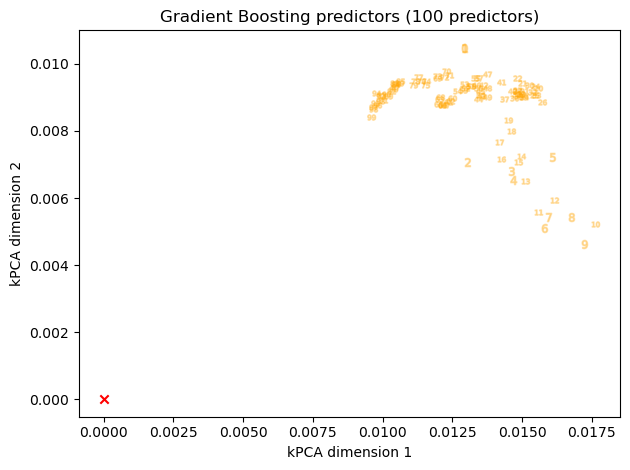

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(0, y_train_behavior_points.shape[0]) :
    ax.scatter(y_train_behavior_points[i,0], y_train_behavior_points[i,1], marker="$%d$" % i, alpha=0.3, color='orange')
    
# let's add an 'X' for the [0,0] reference
ax.scatter([0.0], [0.0], marker='x', color='red')
    
ax.set_title("Gradient Boosting predictors (%d predictors)" % len(gb_regressor.estimators_))
ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")

plt.tight_layout()

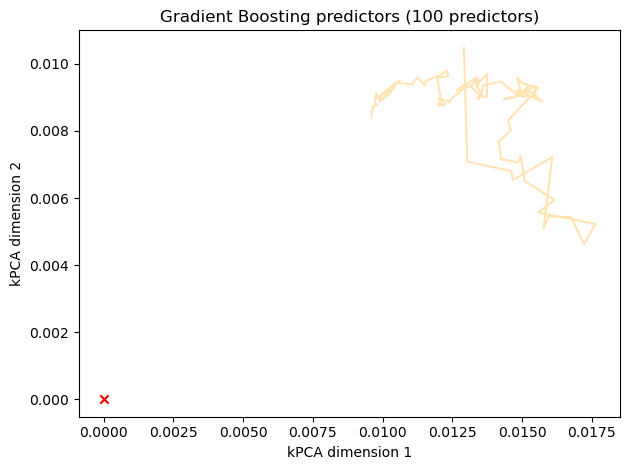

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(y_train_behavior_points[:,0], y_train_behavior_points[:,1], color='orange', alpha=0.3)
    
# let's add an 'X' for the [0,0] reference
ax.scatter([0.0], [0.0], marker='x', color='red')
    
ax.set_title("Gradient Boosting predictors (%d predictors)" % len(gb_regressor.estimators_))
ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")

plt.tight_layout()

In [10]:
lgb_regressor = LGBMRegressor(random_state=random_seed)
lgb_regressor.fit(X_train, y_train)

y_train_pred = lgb_regressor.predict(X_train)
y_test_pred = lgb_regressor.predict(X_test)

performance = r2_score(y_test, y_test_pred)
print("Performance of LightGBM: %.4f" % performance)

Performance of LightGBM: 0.5379


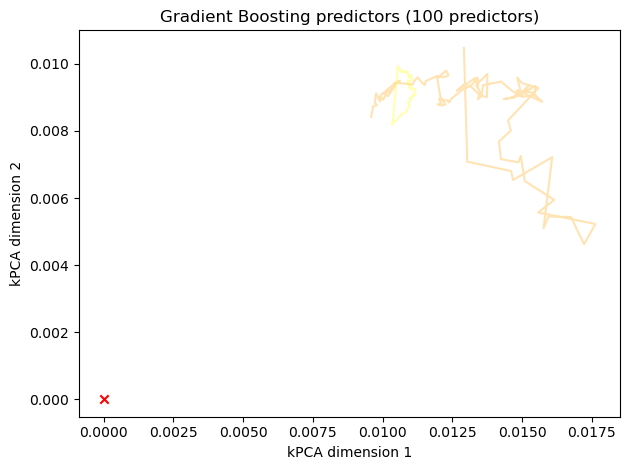

In [18]:
# now, LightGBM actually has a built-in method to provide a prediction adding up all trees up to the i-th iteration
lgb_semantic_points = np.zeros((lgb_regressor.n_estimators, y_train.shape[0]))

for iteration in range(0, lgb_regressor.n_estimators) :
    lgb_semantic_points[iteration] = lgb_regressor.predict(X_train, num_iteration=iteration)
    
lgb_behavior_points = kpca.transform(lgb_semantic_points)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(y_train_behavior_points[:,0], y_train_behavior_points[:,1], color='orange', alpha=0.3)
ax.plot(lgb_behavior_points[:,0], lgb_behavior_points[:,1], color='yellow', alpha=0.3)
ax.scatter([0.0], [0.0], marker='x', color='red')

ax.set_title("Gradient Boosting predictors (%d predictors)" % len(gb_regressor.estimators_))
ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")

plt.tight_layout()